In [165]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tools import clean_data, set_new_names, set_category
import os
import glob


In [166]:
# Ustaw ścieżkę do folderu, który chcesz przeszukać
folder_path = '..\data'

# Ustaw, czy chcesz przeszukać również podfoldery
include_subfolders = True

# Wyszukiwanie plików .csv
if include_subfolders:
    pattern = '**\*.csv'
else:
    pattern = '*.csv'

# Użyj os.path.join, aby uwzględnić ścieżkę folderu
search_pattern = os.path.join(folder_path, pattern)

In [167]:
search_pattern

'..\\data\\**\\*.csv'

In [168]:
csv_files = glob.glob(search_pattern, recursive=include_subfolders)

In [169]:
csv_files

['..\\data\\Lista_transakcji_nr_0165421859_200723.csv',
 '..\\data\\Lista_transakcji_nr_0178969007_300124.csv',
 '..\\data\\Lista_transakcji_nr_0178969233_300124.csv',
 '..\\data\\Lista_transakcji_nr_0178969327_300124.csv',
 '..\\data\\Lista_transakcji_nr_0178969442_300124.csv']

In [170]:
# Wczytaj wszystkie pliki .csv do jednego DataFrame
df = pd.concat((pd.read_csv(file, sep=';', decimal=',', encoding='windows-1250') for file in csv_files), ignore_index=True)

In [171]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16816 entries, 0 to 16815
Data columns (total 28 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Data transakcji                     16816 non-null  object 
 1   Data księgowania                    667 non-null    object 
 2   Dane kontrahenta                    16816 non-null  object 
 3   Tytuł                               686 non-null    object 
 4   Nr rachunku                         15001 non-null  object 
 5   Nazwa banku                         2558 non-null   object 
 6   Szczegóły                           667 non-null    object 
 7   Nr transakcji                       16415 non-null  object 
 8   Kwota transakcji (waluta rachunku)  16422 non-null  float64
 9   Waluta                              16422 non-null  object 
 10  Kwota blokady/zwolnienie blokady    394 non-null    float64
 11  Waluta.1                            394 n

In [172]:
# remove columns if all values are NaN
df.dropna(axis=1, how='all', inplace=True)

In [173]:
df = df[['Data transakcji',
 'Dane kontrahenta',
 'Tytuł',
 'Nr rachunku',
 'Szczegóły',
 'Nr transakcji',
 'Kwota transakcji (waluta rachunku)']]

In [174]:
df.columns = ['date', 'contractor', 'title', 'account_number', 'details', 'transaction_number', 'amount']

In [175]:
def clean_data(df):
    # Drop duplicate rows across all columns
    df = df.drop_duplicates()
    # Drop rows with missing data in columns: 'contractor', 'date' and 2 other columns
    df = df.dropna(subset=['contractor', 'date', 'transaction_number', 'amount'])
    # Drop column: 'details'
    df = df.drop(columns=['details'])
    # Drop column: 'account_number'
    df = df.drop(columns=['account_number'])
    # Remove leading and trailing whitespace in columns: 'contractor', 'title', 'transaction_number'
    df['contractor'] = df['contractor'].str.strip()
    df['title'] = df['title'].str.strip()
    df['transaction_number'] = df['transaction_number'].str.strip()
    # Replace all instances of "'" with "" in column: 'transaction_number'
    df['transaction_number'] = df['transaction_number'].str.replace("'", "", case=False, regex=False)
    # Drop column: 'title'
    df = df.drop(columns=['title'])
    # Drop duplicate rows across all columns
    df = df.drop_duplicates()
    return df

df_clean = clean_data(df.copy())

In [176]:
df_clean.head()

,date,contractor,transaction_number,amount
0,2023-07-20,Dawid Ludwa,202320197209545076,-50.00
3,2023-07-20,"ZUS Centrum Obsługi Świadczeń dla R, odzin, ul...",202320197203279992,500.00
4,2023-07-19,"LUDWA DAWID JAN, i LUDWA ANNA, EDMUNDA CIEĆKIE...",202320097202882525,1000.00
11,2023-07-18,LIDL LUKASINSKIEGO Nowy Sacz POL,202320197304224746,-56.20
12,2023-07-18,PIEKARNIA ORACZ A. ORACZ NOWY SACZ,202320197301037340,-40.57


In [177]:
# drop duplicates in column both
df_clean = df_clean.drop_duplicates(subset=['transaction_number'], keep=False)

In [178]:
df = df_clean.copy()

In [179]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8123 entries, 0 to 16811
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                8123 non-null   object 
 1   contractor          8123 non-null   object 
 2   transaction_number  8123 non-null   object 
 3   amount              8123 non-null   float64
dtypes: float64(1), object(3)
memory usage: 317.3+ KB


In [180]:
df['date'] = df['date'].astype('datetime64[ns]')

In [181]:
df = df[['date', 'contractor', 'amount']]

In [182]:
df.rename(columns={'date': 'date', 'contractor': 'details', 'amount': 'amount'}, inplace=True)

In [183]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8123 entries, 0 to 16811
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     8123 non-null   datetime64[ns]
 1   details  8123 non-null   object        
 2   amount   8123 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 253.8+ KB


In [184]:
df = set_new_names(df.copy())
df["details_2"].fillna("not set", inplace=True)
df = set_category(df.copy())

df['category'].fillna('other', inplace=True)
df['category'] = df['category'].str.lower()
df['details'] = df['details'].str.lower()
df['category'] = df['category'].astype('category')

df['y_m'] = df['date'].dt.to_period('M')
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day

In [185]:
df.head()

,date,details,amount,details_2,category,y_m,year,month,day
0,2023-07-20,dawid ludwa,-50.00,not set,other,2023-07,2023,7,20
11,2023-07-18,lidl lukasinskiego nowy sacz pol,-56.20,lidl,grocery store,2023-07,2023,7,18
12,2023-07-18,piekarnia oracz a. oracz nowy sacz,-40.57,oracz,grocery store,2023-07,2023,7,18
13,2023-07-18,jmp s.a. biedronka 4028 nowy sacz,-9.87,biedronka,grocery store,2023-07,2023,7,18
14,2023-07-18,jmp s.a. biedronka 4028 nowy sacz,-57.81,biedronka,grocery store,2023-07,2023,7,18


In [186]:
df = df[~df['details'].str.contains('ludwa|anna|dawid|inter-bud|currency one|unikorona|katarzyna predka|ext ltd')]

In [187]:
df_expenses = df[df['amount'] < 0].copy()

In [188]:
min(df_expenses['amount']), max(df_expenses['amount'])

(-6560.0, -0.02)

In [189]:
df_expenses.sort_values(by='amount', ascending=True).head(50)

,date,details,amount,details_2,category,y_m,year,month,day
1061,2023-10-30,kancelaria notarialna s krakow po,-6560.00,not set,other,2023-10,2023,10,30
4518,2021-08-04,revolut 5883 internet lt,-3000.00,revolut,other,2021-08,2021,8,4
221,2023-05-31,ryanair k67e6r0 00000k67e6 irl,-2973.40,ryanair,transport vacation,2023-05,2023,5,31
4711,2021-07-01,jysk sp z oo pp440 nowy sacz pl,-2915.00,jysk,retail,2021-07,2021,7,1
7502,2020-08-28,amso krakow czarnowiejska krakow 30,-2459.02,not set,other,2020-08,2020,8,28
2870,2022-09-06,ryanair dublin irl,-2456.71,ryanair,transport vacation,2022-09,2022,9,6
2324,2023-01-10,decathlon sp. z o.o. warszawa pol,-2449.00,decathlon,other,2023-01,2023,1,10
985,2023-11-18,"urzďż˝d miasta krakowa wydziaďż˝ skarbu, miasta",-2438.00,not set,other,2023-11,2023,11,18
4486,2021-08-11,agata nowy sacz nowy sacz pl,-2425.11,not set,other,2021-08,2021,8,11
7370,2020-10-01,"zobacz ďż˝ycie - krystian koc, ul. staromiejsk...",-2400.00,not set,other,2020-10,2020,10,1


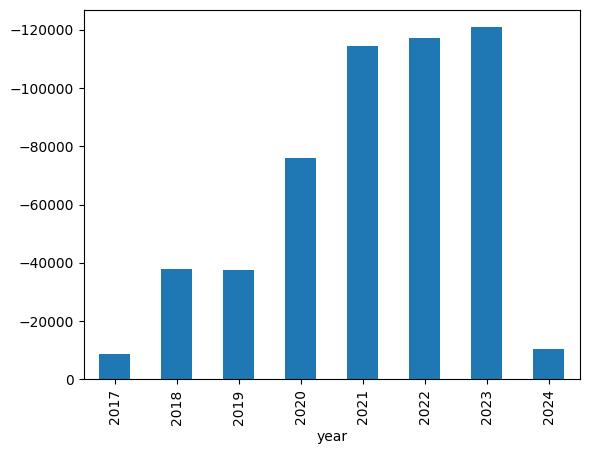

In [190]:
df_expenses.groupby(by='year')['amount'].sum().plot(kind='bar')
# invert y axis
plt.gca().invert_yaxis()
plt.show()

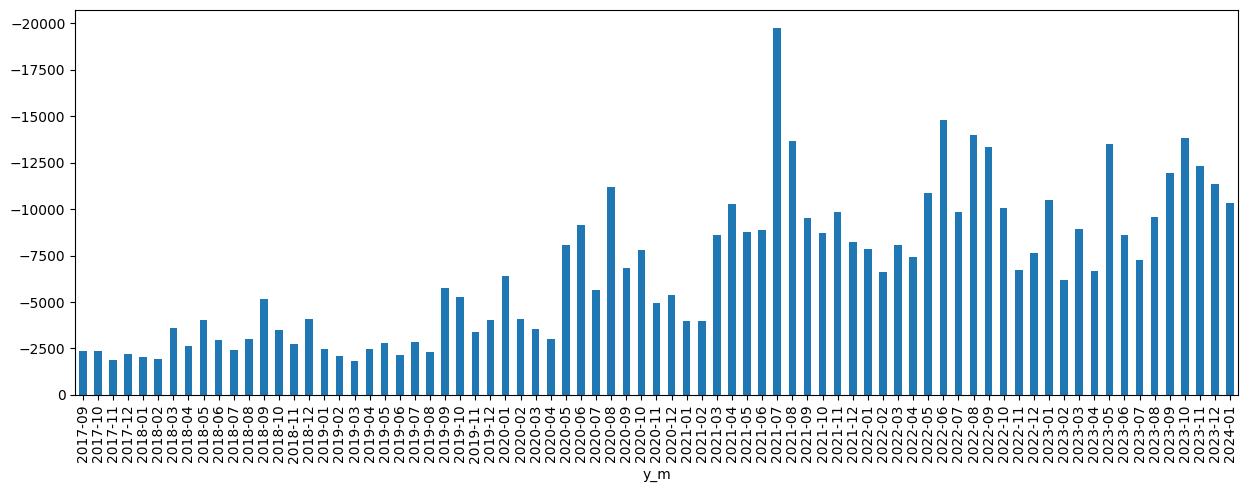

In [191]:
df_expenses.groupby(by='y_m')['amount'].sum().plot(kind='bar', figsize=(15, 5))
# invert y axis
plt.gca().invert_yaxis()
plt.show()

In [192]:
# get last 6 months
df_expenses_last_6_months = df_expenses[df_expenses['date'] > '2022-12-31']

In [193]:
df_expenses_last_6_months.head()

,date,details,amount,details_2,category,y_m,year,month,day
11,2023-07-18,lidl lukasinskiego nowy sacz pol,-56.20,lidl,grocery store,2023-07,2023,7,18
12,2023-07-18,piekarnia oracz a. oracz nowy sacz,-40.57,oracz,grocery store,2023-07,2023,7,18
13,2023-07-18,jmp s.a. biedronka 4028 nowy sacz,-9.87,biedronka,grocery store,2023-07,2023,7,18
14,2023-07-18,jmp s.a. biedronka 4028 nowy sacz,-57.81,biedronka,grocery store,2023-07,2023,7,18
15,2023-07-18,spp b17 narutowicza nowy sacz pol,-3.00,not set,other,2023-07,2023,7,18


In [194]:
df_expenses_last_6_months['y_m'].unique()

<PeriodArray>
['2023-07', '2023-06', '2023-05', '2023-04', '2023-03', '2023-02', '2023-01',
 '2024-01', '2023-12', '2023-11', '2023-10', '2023-09', '2023-08']
Length: 13, dtype: period[M]

In [195]:
ff =df_expenses_last_6_months.pivot_table(index='category', columns='y_m', values='amount', aggfunc='sum', fill_value=0)

In [196]:
df_filtered = ff.loc[~(ff == 0).all(axis=1)]

In [197]:
df_filtered

y_m,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08,2023-09,2023-10,2023-11,2023-12,2024-01
category,,,,,,,,,,,,,
alcosol,0.00,0.00,-8.68,0.00,0.00,-51.91,0.00,0.00,0.00,0.00,0.00,0.00,0.00
car,-349.80,-447.81,-369.96,-330.86,0.00,-667.12,-332.75,-360.69,-153.06,-88.66,-711.50,-426.06,-229.40
clothes,0.00,-32.69,-1032.63,-49.10,0.00,0.00,0.00,0.00,-169.80,0.00,0.00,-31.89,-90.96
dentist,0.00,0.00,-120.00,-380.00,-270.00,-880.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
entertainment,-81.99,-81.99,-81.99,-53.00,-43.00,-43.00,0.00,-43.00,-43.00,-43.00,-10.00,0.00,0.00
financial services,-263.50,-1053.21,-1411.03,-633.92,-2001.10,-670.87,-1400.92,-334.31,-372.40,-269.58,-2156.67,-1251.68,-1851.98
food service,-124.00,0.00,-32.50,-3.71,-53.49,-25.80,-53.30,-1.94,-22.50,0.00,-49.60,-27.40,0.00
grocery store,-2097.74,-2432.04,-2584.12,-2305.59,-2848.88,-2087.75,-2289.90,-2519.19,-2175.69,-1900.11,-1840.35,-2062.22,-2078.15
healthcare,-249.52,-303.83,-568.40,-124.66,-180.73,-241.91,-807.31,-385.20,-419.87,-265.01,-175.43,-482.39,-197.53


In [198]:
# ADD COLUMN WITH TOTAL SUM
df_filtered['total'] = df_filtered.sum(axis=1)
# ADD ROW WITH TOTAL SUM
df_filtered.loc['total'] = df_filtered.sum()

C:\Users\dawid\AppData\Local\Temp\ipykernel_18216\741723174.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['total'] = df_filtered.sum(axis=1)
C:\Users\dawid\AppData\Local\Temp\ipykernel_18216\741723174.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.loc['total'] = df_filtered.sum()


In [199]:
df_filtered.reset_index(inplace=True)

In [200]:
#df_filtered = df_filtered[df_filtered['total'] < -200]
#df_filtered = df_filtered[df_filtered['category'] != 'ps']

In [205]:
df_expenses.head()

,date,details,amount,details_2,category,y_m,year,month,day
11,2023-07-18,lidl lukasinskiego nowy sacz pol,-56.20,lidl,grocery store,2023-07,2023,7,18
12,2023-07-18,piekarnia oracz a. oracz nowy sacz,-40.57,oracz,grocery store,2023-07,2023,7,18
13,2023-07-18,jmp s.a. biedronka 4028 nowy sacz,-9.87,biedronka,grocery store,2023-07,2023,7,18
14,2023-07-18,jmp s.a. biedronka 4028 nowy sacz,-57.81,biedronka,grocery store,2023-07,2023,7,18
15,2023-07-18,spp b17 narutowicza nowy sacz pol,-3.00,not set,other,2023-07,2023,7,18


In [208]:
df_expenses[df_expenses['category'] == 'ps'].sort_values(by='date', ascending=True).head(50)

,date,details,amount,details_2,category,y_m,year,month,day
15495,2018-09-16,ulsaskalipska krakow pl,-100.00,not set,ps,2018-09,2018,9,16
15488,2018-09-17,ul.saska/lipska krakow,-2.50,not set,ps,2018-09,2018,9,17
8984,2019-06-05,"zabka z2384 k.1, ul. lipska 53/7b, krakow",-11.00,zabka,ps,2019-06,2019,6,5
7553,2020-08-12,restauracja chlopsk glogoczow pl,-75.96,not set,ps,2020-08,2020,8,12
7430,2020-09-16,koral spj psd 2 krakow pl,-2.39,not set,ps,2020-09,2020,9,16
3733,2022-02-10,sklep nr 96 pss spolem nowy sacz pl,-18.76,not set,ps,2022-02,2022,2,10
3289,2022-06-06,centrum med. batorego .ps nowy sac,-195.00,delkatesy,ps,2022-06,2022,6,6
3038,2022-08-02,centrum med. batorego .ps nowy sac,-195.00,delkatesy,ps,2022-08,2022,8,2
2886,2022-09-01,todoist httpstodo,-6.83,not set,ps,2022-09,2022,9,1
2887,2022-09-01,todoist httpstodo,-227.77,not set,ps,2022-09,2022,9,1


In [202]:
df_filtered

y_m,category,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08,2023-09,2023-10,2023-11,2023-12,2024-01,total
0,alcosol,0.00,0.00,-8.68,0.00,0.00,-51.91,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-60.59
1,car,-349.80,-447.81,-369.96,-330.86,0.00,-667.12,-332.75,-360.69,-153.06,-88.66,-711.50,-426.06,-229.40,-4467.67
2,clothes,0.00,-32.69,-1032.63,-49.10,0.00,0.00,0.00,0.00,-169.80,0.00,0.00,-31.89,-90.96,-1407.07
3,dentist,0.00,0.00,-120.00,-380.00,-270.00,-880.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1650.00
4,entertainment,-81.99,-81.99,-81.99,-53.00,-43.00,-43.00,0.00,-43.00,-43.00,-43.00,-10.00,0.00,0.00,-523.97
5,financial services,-263.50,-1053.21,-1411.03,-633.92,-2001.10,-670.87,-1400.92,-334.31,-372.40,-269.58,-2156.67,-1251.68,-1851.98,-13671.17
6,food service,-124.00,0.00,-32.50,-3.71,-53.49,-25.80,-53.30,-1.94,-22.50,0.00,-49.60,-27.40,0.00,-394.24
7,grocery store,-2097.74,-2432.04,-2584.12,-2305.59,-2848.88,-2087.75,-2289.90,-2519.19,-2175.69,-1900.11,-1840.35,-2062.22,-2078.15,-29221.73
8,healthcare,-249.52,-303.83,-568.40,-124.66,-180.73,-241.91,-807.31,-385.20,-419.87,-265.01,-175.43,-482.39,-197.53,-4401.79
9,home improvement,-192.12,-605.40,-137.14,-424.81,-1266.29,-109.38,-209.84,0.00,-500.83,-203.29,0.00,0.00,-269.55,-3918.65
